# Batch Normalization

In this task, we implement batch normalization, which normalizes hidden layers and makes the training procedure more stable. 

Reference: [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [2]:
# As usual, a bit of setup
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from data_utils import get_CIFAR10_data
from implementations.layers import batchnorm_forward

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: forward
In the file `implementations/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above would be helpful!

In [4]:
# A very simple example

xtrain = np.array([[10], [20], [30]])

xtest = np.array([[25]])


# initialize parameters for batch normalization
bn_param = {}
bn_param['mode'] = 'train'
bn_param['eps'] = 1e-4
bn_param['momentum'] = 0.95

# initialize the running mean as zero and the running variance as one 
bn_param['running_mean'] = np.zeros([1, xtrain.shape[1]])
bn_param['running_var'] = np.ones([1, xtrain.shape[1]])

# gamma and beta do not make changes to the standardization result from the first step. 
gamma = np.ones([1])
beta = np.zeros([1])

print('Before batch normalization, xtrain has ')
print_mean_std(xtrain,axis=0)

xnorm = batchnorm_forward(xtrain, gamma, beta, bn_param)

print('After batch normalization, xtrain has ')
print_mean_std(xnorm,axis=0) # The mean and std should be 0 and 1 respectively


print('After batch normalization, the running mean and the running variance are updated to')
print(bn_param['running_mean']) # should be 1.0
print(bn_param['running_var']) # should be 4.283


for iter in range(1000):
    xnorm = batchnorm_forward(xtrain, gamma, beta, bn_param)
    
print('After many iterations, the running mean and the running variance are updated to')
print(bn_param['running_mean']) # should be 20, the mean of xtrain
print(bn_param['running_var']) # should be 66.667, the variance of xtrain


# enter test mode, 
bn_param['mode'] = 'test'
xtest_norm = batchnorm_forward(xtest, gamma, beta, bn_param)

print('Before batch normalization, xtest becomes ') # should be [[0.61237198]]
print(xtest_norm)


Before batch normalization, xtrain has 
  means:  [20.]
  stds:   [8.16496581]

After batch normalization, xtrain has 
  means:  [0.]
  stds:   [0.99999925]

After batch normalization, the running mean and the running variance are updated to
[[1.]]
[[4.28333333]]
After many iterations, the running mean and the running variance are updated to
[[20.]]
[[66.66666667]]
Before batch normalization, xtest becomes 
[[0.61237198]]


In [34]:
# Compare with tf.layers.batch_normalization 

# Simulate the forward pass for a two-layer network
np.random.seed(15009)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)

W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)


# initialize parameters for batch normalization
bn_param = {}
bn_param['mode'] = 'train'
bn_param['eps'] = 1e-4
bn_param['momentum'] = 0.95
bn_param['running_mean'] = np.zeros([1, a.shape[1]])
bn_param['running_var'] = np.ones([1, a.shape[1]])

# random gamma and beta
gamma = np.random.rand(D3) + 1.0
beta = np.random.rand(D3)


# Setting up a tensorflow bn layer using the same set of parameters. 

tf.reset_default_graph()
tfa = tf.placeholder(tf.float32, shape=[None, a.shape[1]])

# used to control the mode
is_training = tf.placeholder_with_default(False, (), 'is_training')

# the axis setting is a little strange to me. But you can understand it as that the axis is along 
# the running mean
tfa_norm = tf.layers.batch_normalization(tfa, axis=1, momentum=0.95, epsilon=bn_param['eps'],
                                         beta_initializer=tf.constant_initializer(beta), 
                                         gamma_initializer=tf.constant_initializer(gamma), 
                                         moving_mean_initializer=tf.zeros_initializer(), 
                                         moving_variance_initializer=tf.ones_initializer(), 
                                         training=is_training)

# this operation is for undating running mean and running variance. 
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

session = tf.Session()

# initialize parameters
session.run(tf.global_variables_initializer())


outputs = []
nbatch = 3
batch_size=10
                     
for ibatch in range(nbatch):
    
    # fetch the batch
    a_batch = a[ibatch * batch_size : (ibatch + 1) * batch_size]
    
    # batch normlaization with your implementation
    a_nprun = batchnorm_forward(a_batch, gamma, beta, bn_param)
    
    # batch normalization with the tensorflow layer. Also update the running mean and variance. 
    a_tfrun, _ = session.run([tfa_norm, update_ops], feed_dict={tfa: a_batch.astype(np.float32), is_training: True})
    
    print("Training batch %d: difference from the two implementations is %f" % (ibatch, rel_error(a_nprun, a_tfrun)))

    
# enterining test mode    
bn_param['mode'] = 'test'
          
for ibatch in range(nbatch):
    a_batch = a[ibatch * batch_size : (ibatch + 1) * batch_size]
    
    a_nprun = batchnorm_forward(a_batch, gamma, beta, bn_param)
    
    # run batch normalization in test mode. No need to update the running mean and variance. 
    a_tfrun = session.run(tfa_norm, feed_dict={tfa: a_batch.astype(np.float32)})

    
    print("Test batch %d: difference from the two implementations is %f" % (ibatch, rel_error(a_nprun, a_tfrun)))
    

Training batch 0: difference from the two implementations is 0.000001
Training batch 1: difference from the two implementations is 0.000015
Training batch 2: difference from the two implementations is 0.000001
Test batch 0: difference from the two implementations is 0.000000
Test batch 1: difference from the two implementations is 0.000000
Test batch 2: difference from the two implementations is 0.000002


## Fully Connected Nets with Batch Normalization
Now that you have a working implementation for batch normalization. Then you need to go back to your `FullyConnectedNet` in the file `implementations/fc_net.py`. Modify the implementation to add batch normalization.

When the `use_bn` flag is set, the network should apply batch normalization before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. 


# Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [5]:
from implementations.fc_net import FullyConnectedNet

np.random.seed(15009)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000

X_train = data['X_train'][:num_train]
X_train = np.reshape(X_train, [X_train.shape[0], -1])
y_train = data['y_train'][:num_train]
                               
X_val = data['X_val']
X_val = np.reshape(X_val, [X_val.shape[0], -1])
y_val = data['y_val']


bn_model = FullyConnectedNet(input_size=X_train.shape[1], 
                             hidden_size=hidden_dims, 
                             output_size=10, 
                             centering_data=True, 
                             use_dropout=False, 
                             use_bn=True)

# use an aggresive learning rate
bn_trace = bn_model.train(X_train, y_train, X_val, y_val,
                          learning_rate=5e-4,
                          reg=np.float32(0.01), 
                          keep_prob=0.5,
                          num_iters=800,
                          batch_size=100, 
                          verbose=True) # train the model with batch normalization

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
iteration 0 / 800: objective 232.335617
iteration 100 / 800: objective 62.526760
iteration 200 / 800: objective 5.490889
iteration 300 / 800: objective 3.853646
iteration 400 / 800: objective 3.367236
iteration 500 / 800: objective 3.126927
iteration 600 / 800: objective 2.983306
iteration 700 / 800: objective 2.886577


Train a fully connected network without batch normalization

In [6]:
model = FullyConnectedNet(input_size=X_train.shape[1], 
                          hidden_size=hidden_dims, 
                          output_size=10, 
                          centering_data=True, 
                          use_dropout=False, 
                          use_bn=False)

# use an aggresive learning rate
baseline_trace = model.train(X_train, y_train, X_val, y_val,
                            learning_rate=5e-4,
                            reg=np.float32(0.01), 
                            num_iters=800,
                            batch_size=100, 
                            verbose=True) # train the model without batch normalization

iteration 0 / 800: objective 232.582138
iteration 100 / 800: objective 206.320709
iteration 200 / 800: objective 176.051270
iteration 300 / 800: objective 89.852188
iteration 400 / 800: objective 145.754822
iteration 500 / 800: objective 149.130859
iteration 600 / 800: objective 32.878620
iteration 700 / 800: objective 67.951195


Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

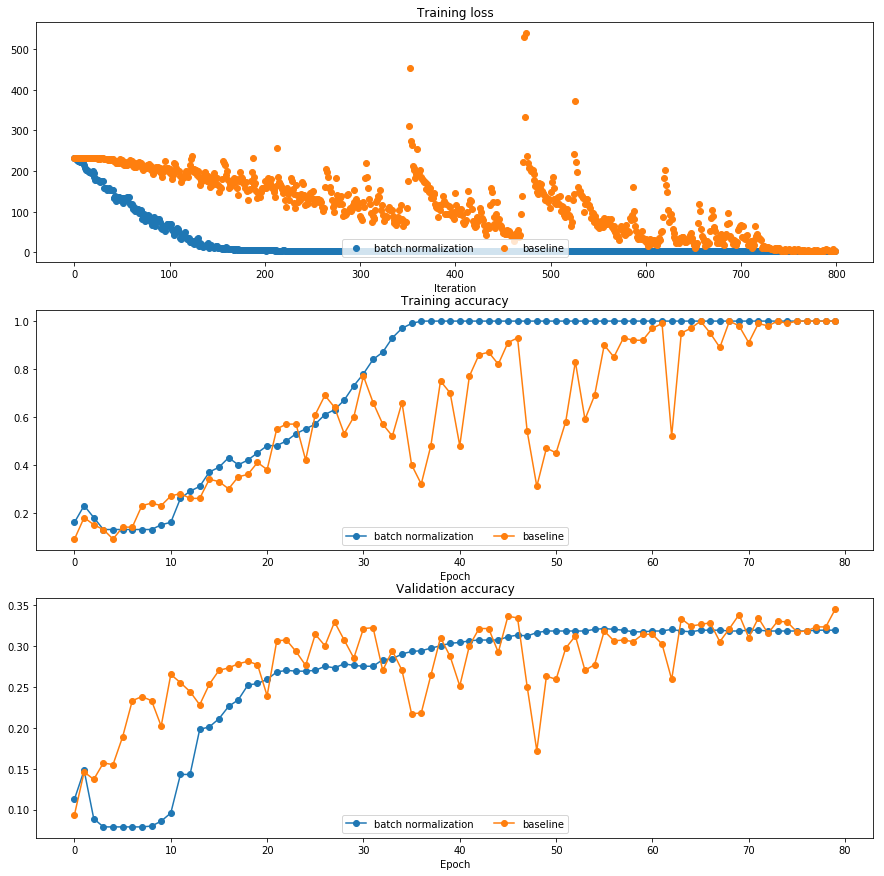

In [7]:
def plot_training_history(title, label, bl_plot, bn_plots, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    num_bn = len(bn_plots)
    
    for i in range(num_bn):
        label='batch normalization'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
        
    label='baseline'
    if labels is not None:
        label += str(labels[0])
        
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', baseline_trace['objective_history'], \
                      [bn_trace['objective_history']], bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', baseline_trace['train_acc_history'], \
                      [bn_trace['train_acc_history']], bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', baseline_trace['val_acc_history'], \
                      [bn_trace['val_acc_history']], bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second cell will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

LIPING: I tried multiple configurations, but I did not find significant improvement from batch normalization. See if you can get clear improvement with your configurations. 

In [ ]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 10000

X_train = data['X_train'][:num_train]
X_train = np.reshape(X_train, [X_train.shape[0], -1])
y_train = data['y_train'][:num_train]
                               
X_val = data['X_val']
X_val = np.reshape(X_val, [X_val.shape[0], -1])
y_val = data['y_val']

bn_net_ws = {}
baseline_ws = {}

weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale=%f at round %d / %d' % (weight_scale, i + 1, len(weight_scales)))


  bn_model = FullyConnectedNet(input_size=X_train.shape[1], 
                             hidden_size=hidden_dims, 
                             output_size=10, 
                             centering_data=True, 
                             use_dropout=False, 
                             use_bn=True)

  # use an aggresive learning rate
  bn_net_ws[weight_scale] = bn_model.train(X_train, y_train, X_val, y_val,
                          learning_rate=1e-2,
                          reg=np.float32(1e-5), 
                          keep_prob=0.5,
                          num_iters=1000,
                          batch_size=100, 
                          verbose=True) # train the model with batch normalization


  model = FullyConnectedNet(input_size=X_train.shape[1], 
                          hidden_size=hidden_dims, 
                          output_size=10, 
                          centering_data=True, 
                          use_dropout=False, 
                          use_bn=True)

  # use an aggresive learning rate
  baseline_ws[weight_scale] = model.train(X_train, y_train, X_val, y_val,
                            learning_rate=1e-2,
                            reg=np.float32(1e-5), 
                            num_iters=1000,
                            batch_size=100, 
                            verbose=True) 



Running weight scale=0.000100 at round 1 / 20
iteration 0 / 1000: objective 233.189835
iteration 100 / 1000: objective 213.591492
iteration 200 / 1000: objective 200.433151
iteration 300 / 1000: objective 187.779266
iteration 400 / 1000: objective 175.908569
iteration 500 / 1000: objective 169.276962
iteration 600 / 1000: objective 166.379684
iteration 700 / 1000: objective 158.826981
iteration 800 / 1000: objective 147.057220
iteration 900 / 1000: objective 145.747345
iteration 0 / 1000: objective 230.705185
iteration 100 / 1000: objective 217.186539
iteration 200 / 1000: objective 201.979187
iteration 300 / 1000: objective 196.978333
iteration 400 / 1000: objective 196.514465
iteration 500 / 1000: objective 188.552139
iteration 600 / 1000: objective 176.873596
iteration 700 / 1000: objective 168.814529
iteration 800 / 1000: objective 161.952850
iteration 900 / 1000: objective 161.383911
Running weight scale=0.000162 at round 2 / 20
iteration 0 / 1000: objective 231.216522
iteration 1

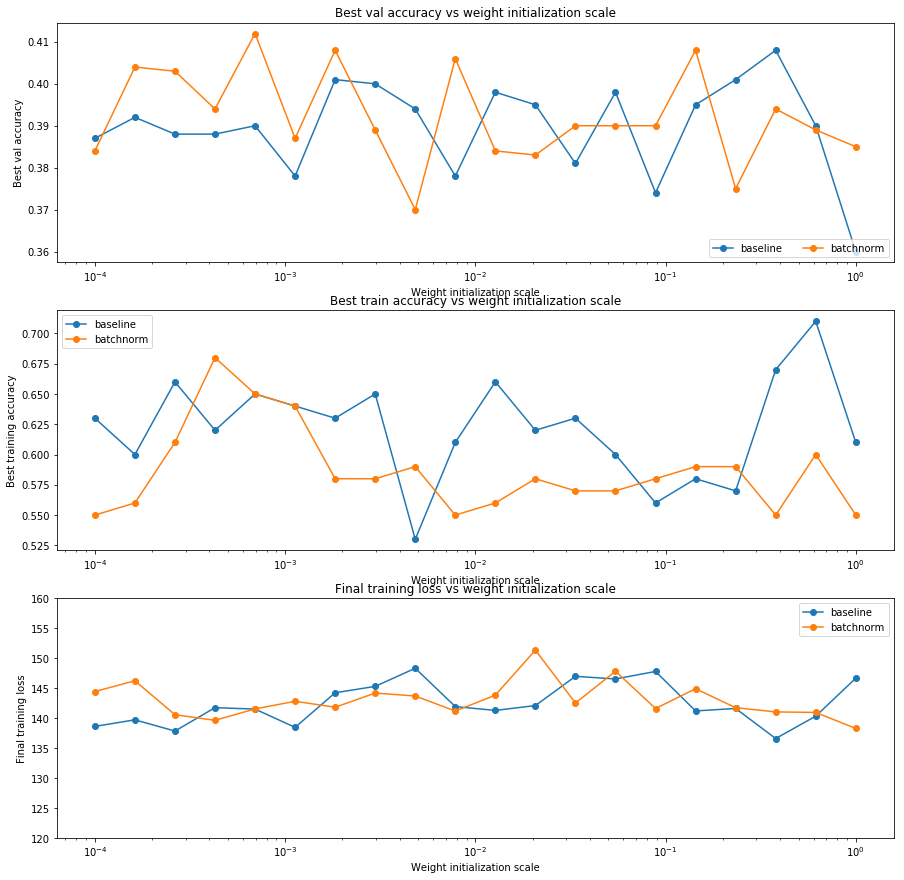

In [45]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(baseline_ws[ws]['train_acc_history']))
  bn_best_train_accs.append(max(bn_net_ws[ws]['train_acc_history']))
  
  best_val_accs.append(max(baseline_ws[ws]['val_acc_history']))
  bn_best_val_accs.append(max(bn_net_ws[ws]['val_acc_history']))
  
  final_train_loss.append(np.mean(baseline_ws[ws]['objective_history'][-100:]))
  bn_final_train_loss.append(np.mean(bn_net_ws[ws]['objective_history'][-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(120, 160)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the scale of weight initialization affect models with/without batch normalization differently, and why?

## Answer:
batch normalization reduces train's dependency on weight initialization.

# Batch normalization and batch size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second cell will plot training accuracy and validation set accuracy over time.

Here is a link about batch sizes in batch normalization:
https://www.graphcore.ai/posts/revisiting-small-batch-training-for-deep-neural-networks


In [46]:
def run_batchsize_experiments():
    np.random.seed(15009)
    # Try training a very deep net with batchnorm
    hidden_dims = [50, 50, 50, 50, 50]
    
    num_train = 1000

    X_train = data['X_train'][:num_train]
    X_train = np.reshape(X_train, [X_train.shape[0], -1])
    y_train = data['y_train'][:num_train]
                               
    X_val = data['X_val']
    X_val = np.reshape(X_val, [X_val.shape[0], -1])
    y_val = data['y_val']
    
    num_epochs = 10
    batch_sizes = [5,10,50]
    

    batch_size = batch_sizes[0]
    print('No normalization: batch size = ', 5)    
    baseline = FullyConnectedNet(input_size=X_train.shape[1], 
                             hidden_size=hidden_dims, 
                             output_size=10,
                             centering_data=True, 
                             use_dropout=False, 
                             use_bn=False)

    # use an aggresive learning rate
    baseline_trace = baseline.train(X_train, y_train, X_val, y_val,
                                    learning_rate=10**-3,
                                    reg=np.float32(1e-5), 
                                    num_iters=num_train * num_epochs // batch_size ,
                                    batch_size=batch_size, 
                                    verbose=True) # train the model with batch normalization

    
    
    

    bn_traces = []
    for i in range(len(batch_sizes)):
        
        batch_size = batch_sizes[i]
        print('Normalization: batch size = ',batch_size)

    
        bn_model = FullyConnectedNet(input_size=X_train.shape[1], 
                             hidden_size=hidden_dims, 
                             output_size=10, 
                             centering_data=True, 
                             use_dropout=False, 
                             use_bn=True)

        # use an aggresive learning rate
        bn_net_trace = bn_model.train(X_train, y_train, X_val, y_val,
                          learning_rate=10**-3,
                          reg=np.float32(1e-5), 
                          num_iters=num_train * num_epochs // batch_size ,
                          batch_size=batch_size, 
                          verbose=True) # train the model with batch normalization

    
        bn_traces.append(bn_net_trace)
        
    return bn_traces, baseline_trace, batch_sizes

batch_sizes = [5,10,50]
bn_traces, baseline_trace, batch_sizes = run_batchsize_experiments()

No normalization: batch size =  5
iteration 0 / 2000: objective 11.514305
iteration 100 / 2000: objective 11.530845
iteration 200 / 2000: objective 11.489232
iteration 300 / 2000: objective 11.541492
iteration 400 / 2000: objective 11.467241
iteration 500 / 2000: objective 11.549950
iteration 600 / 2000: objective 11.446713
iteration 700 / 2000: objective 11.555372
iteration 800 / 2000: objective 11.426663
iteration 900 / 2000: objective 11.555120
iteration 1000 / 2000: objective 11.404947
iteration 1100 / 2000: objective 11.544064
iteration 1200 / 2000: objective 11.375858
iteration 1300 / 2000: objective 11.504647
iteration 1400 / 2000: objective 11.316720
iteration 1500 / 2000: objective 11.314795
iteration 1600 / 2000: objective 11.028091
iteration 1700 / 2000: objective 9.682540
iteration 1800 / 2000: objective 10.528840
iteration 1900 / 2000: objective 9.623591
Normalization: batch size =  5
iteration 0 / 2000: objective 11.261142
iteration 100 / 2000: objective 9.951454
iteratio

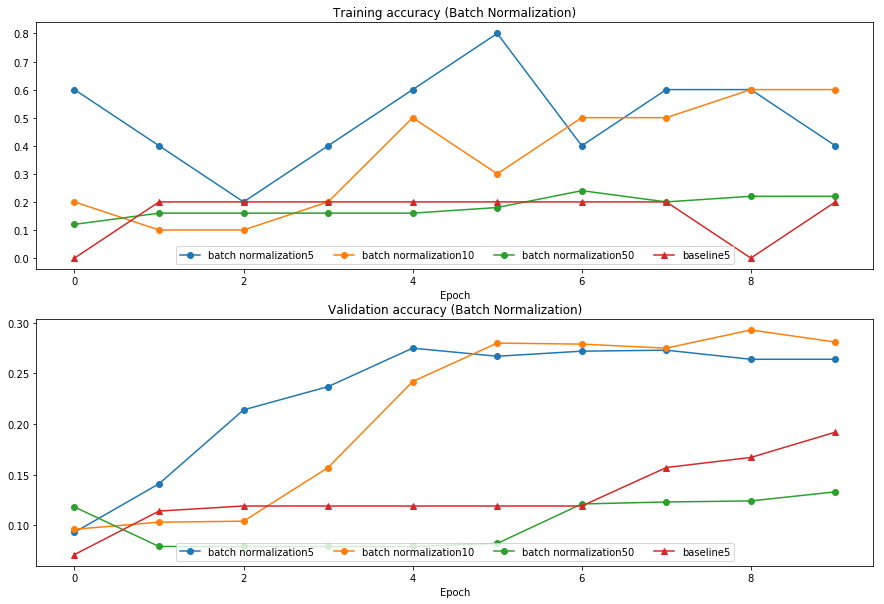

In [17]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', 
                      baseline_trace['train_acc_history'], 
                      [trace['train_acc_history'] for trace in bn_traces],
                      bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', 
                      baseline_trace['val_acc_history'], 
                      [trace['val_acc_history'] for trace in bn_traces],
                      bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

## Answer:
